In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime

from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [5]:
def score_predict(X_test, y_test, pred):

    df = X_test.copy()
    df['true_y'] = y_test
    df['pred_y'] = pred

    match = sum((df.groupby('srch_id')['true_y'].idxmax() == df.groupby('srch_id')['pred_y'].idxmax()) & (df.groupby('srch_id')['true_y'].max() > 1))

    print(sum(df.groupby('srch_id')['true_y'].max() > 1))
    print(df['srch_id'].nunique())

    score = match / df['srch_id'].nunique()
    return score

In [6]:
#score = score_predict(X_test, y_test, pred_test)
# score

In [7]:
data = pd.read_csv('data/training_set_VU_DM.csv')

# data = pd.read_csv('data/FE_training_set.csv')
# data.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
#data['target'] =  data['booking_bool'] + data['click_bool'] + (1 - data['booking_bool']) * (1/data['position'])
data['target'] = data['booking_bool'] + data['click_bool'] + (1-data['booking_bool']) * (41 - data['position']) / 40
data['target'].loc[data['target'].isna()] = int(0)
#data['target'] = data['target'].astype(int)

/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_60001/4162686752.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'].loc[data['target'].isna()] = int(0)


In [9]:
# data['target'] = 1* data['booking_bool'] + data['click_bool']
# data['target'].loc[data['target'].isna()] = int(0)
# data['target'] = data['target'].astype(int)

In [10]:
data.position.max()

40

<Axes: >

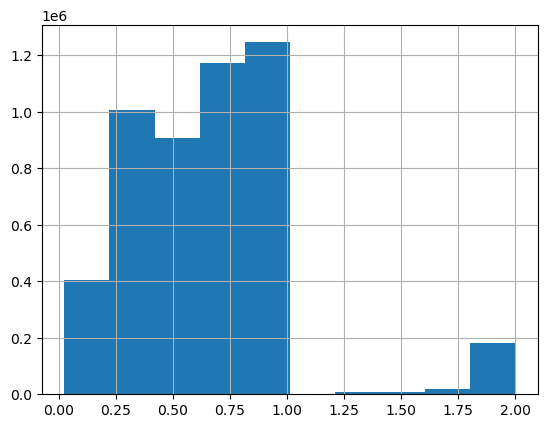

In [11]:
data['target'].hist()
#plt.yscale('log')

In [12]:
data.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,target
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,0.350
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,0.375
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,0.500
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0,0.175
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,0.925


In [13]:
# get search ids with any booking
ids = data['srch_id'].loc[data['booking_bool'] == 1].unique()

In [14]:
# use only the searches that resulted in a booking
data = data.loc[data['srch_id'].isin(ids)]

In [15]:
#undersample non bookings
X_under, y_under = resample(data.drop(['click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
                                      , axis=1).loc[data['target'] < 1], data['target'].loc[data['target'] < 1]
                                      , n_samples= 2* sum(data['target'] > 1), replace=False)

In [16]:
X_bal = pd.concat([X_under, data.drop(['click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
                                      , axis=1).loc[data['target'] > 1]])

y_bal = y_under
y_bal = y_bal.append(data['target'].loc[data['target'] > 1])

/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_60001/182891361.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_bal = y_bal.append(data['target'].loc[data['target'] > 1])


(array([ 27615.,  67592.,  60563.,  77932.,  71232.,    337.,   1148.,
          1648.,   3400., 145934.]),
 array([0.025 , 0.2225, 0.42  , 0.6175, 0.815 , 1.0125, 1.21  , 1.4075,
        1.605 , 1.8025, 2.    ]),
 <BarContainer object of 10 artists>)

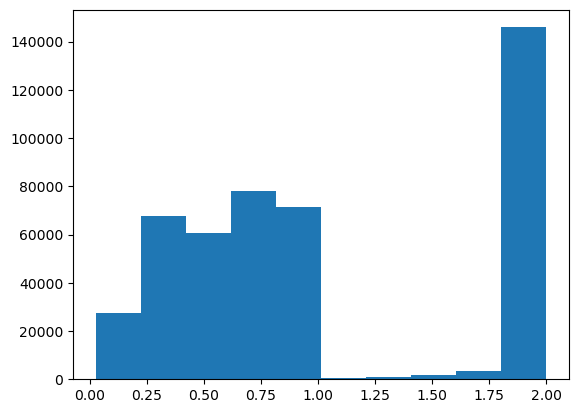

In [17]:
plt.hist(y_bal)

In [18]:
# X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal)

#X_train, X_test, y_train, y_test = train_test_split(data.drop(['click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
#                                       , axis=1), data['target'])
X_train, y_train = X_bal, y_bal

In [19]:
# much better than just replacing with 0
X_train = X_train.fillna(-9999)
baseline = GradientBoostingRegressor(n_estimators = 100, max_leaf_nodes=None, max_depth=3, min_samples_split=10**4, max_features=int(0.4* X_train.shape[1]), random_state=42)


In [20]:
# hyper param tuning
# param_dist = {'min_samples_split' : [2, 10_000], 'max_depth' : [3, 15]}
# hp_search = HalvingRandomSearchCV(baseline, param_dist, min_resources=50_000).fit(X_train, y_train)

In [21]:
# hp_search.best_params_

In [24]:
baseline.fit(X_train.drop(['srch_id', 'date_time'], axis = 1),y_train)

GradientBoostingRegressor(max_features=20, min_samples_split=10000,
                          random_state=42)

In [ ]:
# pred = baseline.predict(data.drop(['srch_id', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target'], axis=1).fillna(-9999))

In [ ]:
#mean_squared_error(data['target'], pred)

In [25]:
pred_test = baseline.predict(X_test.drop(['srch_id', 'date_time'], axis=1).fillna(-9999))
mean_squared_error(y_test, pred_test)

NameError: name 'X_test' is not defined

In [ ]:
# pred

In [ ]:
# plt.hist(y_train)

## Predict the test dataset and bring it into requested format

In [26]:
# test_data = pd.read_csv('data/FE_test_set.csv')
# test_data.drop('Unnamed: 0', axis=1, inplace=True)

test_data = pd.read_csv('data/test_set_VU_DM.csv')

In [27]:
test_data.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff
0,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,3180,3,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,5543,3,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,14142,2,3.5,...,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,22393,3,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,24194,3,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# test_data['prediction'] = baseline.predict(test_data.drop(['srch_id', 'in_train'], axis=1).fillna(-9999))

test_data['prediction'] = baseline.predict(test_data.drop(['srch_id', 'date_time'], axis=1).fillna(-9999))

In [30]:
# sort values for final format
test_data.sort_values(['srch_id', 'prediction'], axis=0, inplace=True, ignore_index=True, ascending=[True, False])

In [31]:
filename = 'data/predictions/prediction'+str(datetime.now())+'.csv'
test_data[['srch_id', 'prop_id']].to_csv(filename, index=False)